In [1]:
from data import *
from dotenv import load_dotenv
import os

load_dotenv()  # looks for .env in current directory
api_key = os.environ["NIXTLA_API_KEY"]
data = Data(datetime_column='datetime')
data.isolate_city()
data.isolate_portion()
preprocessed_data = data.prepare_for_nixtla()
preprocessed_data.head()

,y,ds,unique_id
0,297.96,2017-06-16 09:00:00,0
1,297.15,2017-06-16 10:00:00,0
2,295.80,2017-06-16 11:00:00,0
3,295.00,2017-06-16 12:00:00,0
4,294.33,2017-06-16 13:00:00,0


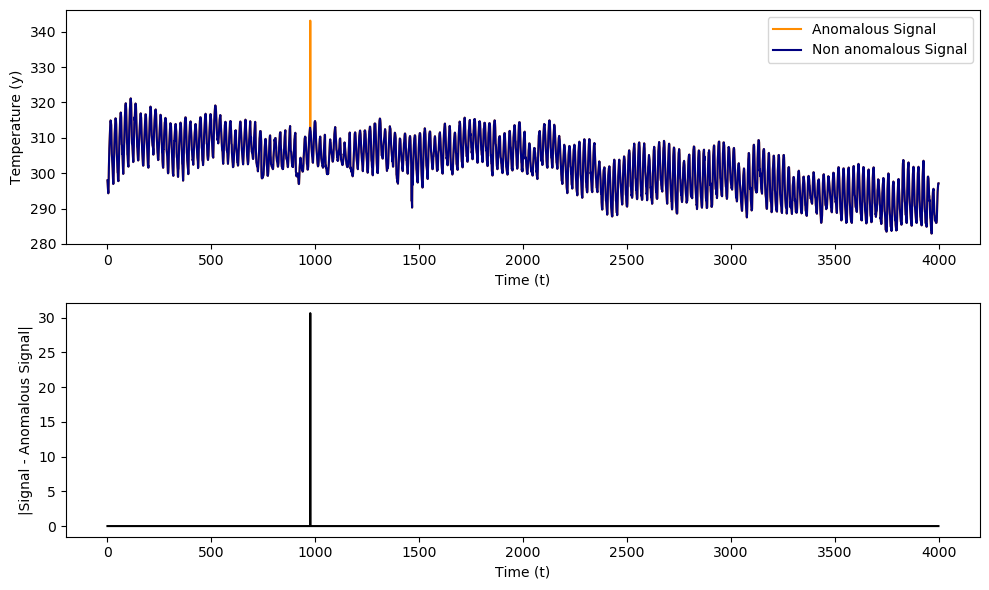

In [2]:
from plotter import *
signal = np.array(preprocessed_data['y'])
position = None
threshold = 0.1
window = 50
anomalous_signal = add_anomaly(signal = signal, position = position, threshold = threshold, window = window)
plot_normal_and_anomalous_signal(signal, anomalous_signal)



In [2]:
import os
import pandas as pd
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(api_key=api_key)

In [3]:
anomalies_df = nixtla_client.detect_anomalies(
    preprocessed_data,
    freq="H",
    model="timegpt-1",
)
anomalies_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


,unique_id,ds,y,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
0,0,2017-06-22 01:00:00,319.60,319.71375,324.28970,315.13780,False
1,0,2017-06-22 02:00:00,319.52,319.36737,323.94333,314.79140,False
2,0,2017-06-22 03:00:00,317.77,318.26680,322.84277,313.69086,False
3,0,2017-06-22 04:00:00,315.15,315.85300,320.42896,311.27704,False
4,0,2017-06-22 05:00:00,312.70,312.91196,317.48790,308.33600,False


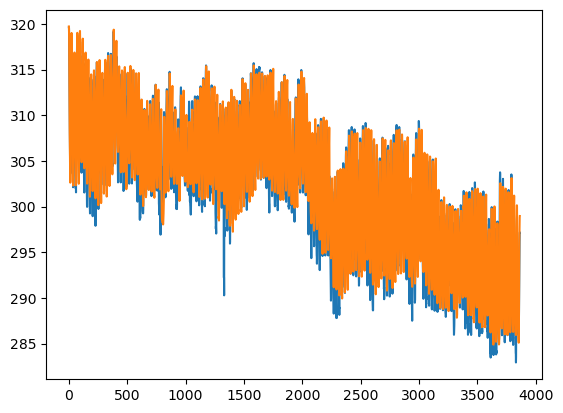

In [4]:
import matplotlib.pyplot as plt
plt.plot(anomalies_df['y'])
plt.plot(anomalies_df['TimeGPT'])

In [34]:
np.arange(-1,1.001,0.001)

[-1.    -0.999 -0.998 ...  0.998  0.999  1.   ]
